In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import keras.layers as layers
import keras.optimizers as optimizers
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from PIL import Image
from skimage.transform import resize
import tensorflow as tf

import threading, random, os

In [44]:
path_dir_img="C:/Users/user/Desktop/TEST/img/"
list_MBimgs=os.listdir(path_dir_img)
path_dir_label="C:/Users/user/Desktop/TEST/label/"
list_MBlabels=os.listdir(path_dir_label)
# print(list_MBfolder,list_MBlabels)

img_joinlist=[]#이미지 디렉션 추출
for i in range(len(list_MBimgs)):
    img_joinlist.append(os.path.join(path_dir_img,list_MBimgs[i]))
print(img_joinlist)

labels_joinlist=[]#라벨 디렉션 
for i in range(len(list_MBlabels)):
    labels_joinlist.append(os.path.join(path_dir_label,list_MBlabels[i]))
print(labels_joinlist)


['C:/Users/user/Desktop/TEST/img/a50.png', 'C:/Users/user/Desktop/TEST/img/a51.png', 'C:/Users/user/Desktop/TEST/img/a52.png', 'C:/Users/user/Desktop/TEST/img/a53.png', 'C:/Users/user/Desktop/TEST/img/a54.png', 'C:/Users/user/Desktop/TEST/img/a55.png', 'C:/Users/user/Desktop/TEST/img/a56.png', 'C:/Users/user/Desktop/TEST/img/a57.png', 'C:/Users/user/Desktop/TEST/img/a58.png', 'C:/Users/user/Desktop/TEST/img/a59.png']
['C:/Users/user/Desktop/TEST/label/50_color_mask.png', 'C:/Users/user/Desktop/TEST/label/51_color_mask.png', 'C:/Users/user/Desktop/TEST/label/52_color_mask.png', 'C:/Users/user/Desktop/TEST/label/53_color_mask.png', 'C:/Users/user/Desktop/TEST/label/54_color_mask.png', 'C:/Users/user/Desktop/TEST/label/55_color_mask.png', 'C:/Users/user/Desktop/TEST/label/56_color_mask.png', 'C:/Users/user/Desktop/TEST/label/57_color_mask.png', 'C:/Users/user/Desktop/TEST/label/58_color_mask.png', 'C:/Users/user/Desktop/TEST/label/59_color_mask.png']


In [67]:
imgs=[]
for img in img_joinlist:
    imgs.append(np.array(Image.open(img)))
imgs

labels=[]
for label in labels_joinlist:
    labels.append(np.array(Image.open(label)))
print(labels)

[array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [255, 255, 255]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [255, 255, 255]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]

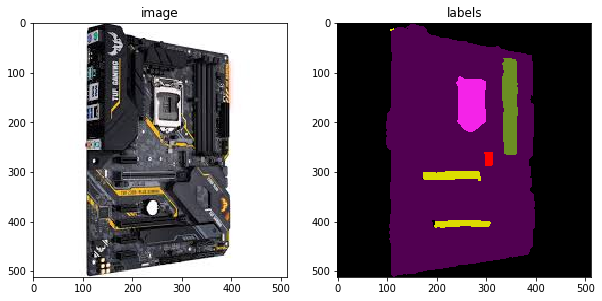

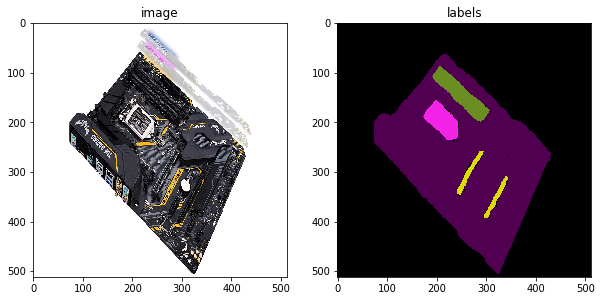

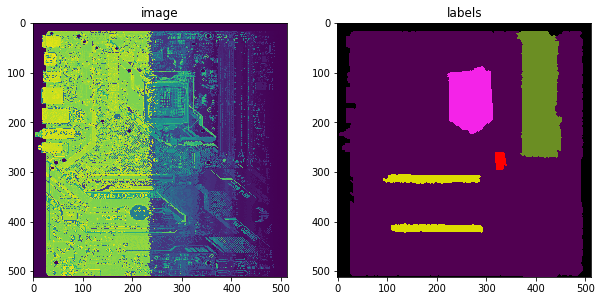

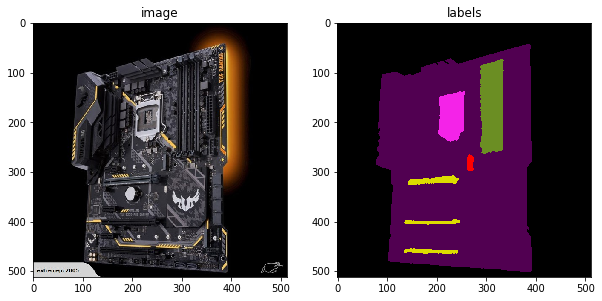

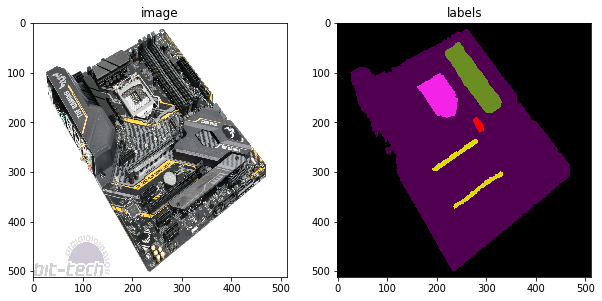

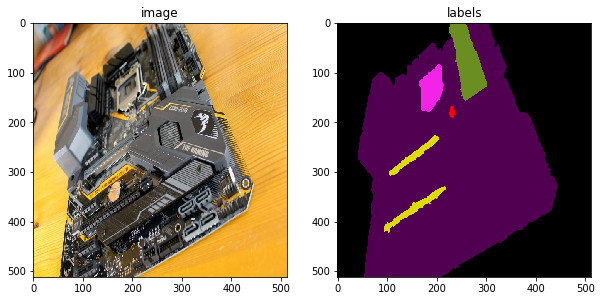

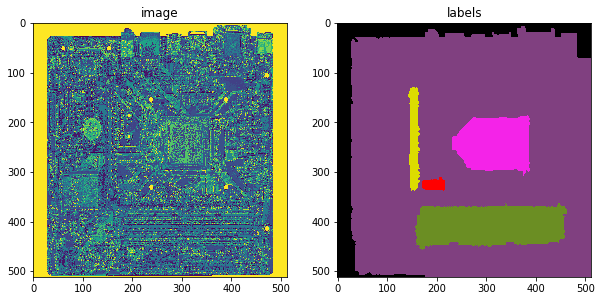

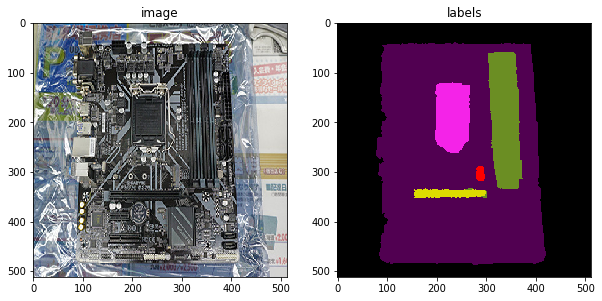

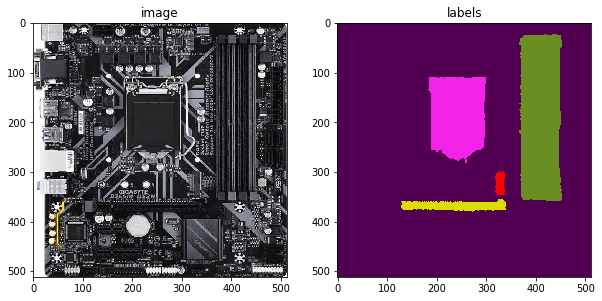

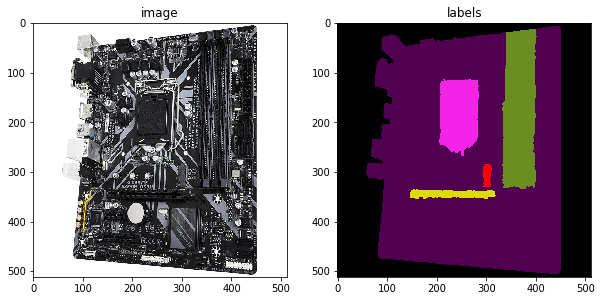

In [56]:
for i in range(10):   
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('image')
    plt.imshow( imgs[i])

    plt.subplot(1, 2, 2)
    plt.title('labels')
    plt.imshow(labels[i])


In [57]:
PANNEL_SIZE = 224

class BatchIndices(object):

    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res
        
class segm_generator(object):

    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True, MB=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.MB = MB
        self.n = x.shape[0]
        self.ri, self.ci = [], []
        for i in range(self.n):
            ri, ci, _ = x[i].shape
            self.ri.append(ri), self.ci.append(ci) 
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o): # 이미지 분할
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):#월리를 기준으로 랜덤으로 슬라이스 
        slice_r = self.get_slice(self.ri[idx], self.ro)
        slice_c = self.get_slice(self.ci[idx], self.co)
        x = self.x[idx][slice_r, slice_c]
        y = self.y[idx][slice_r, slice_c]
        if self.train and (random.random()>0.5):# 0.5의 확률로 뒤집어서 분할
            y = y[:,::-1]
            x = x[:,::-1]
        if not self.MB and np.sum(y)!=0:
            return None

        return x, to_categorical(y, num_classes=2).reshape((y.shape[0] * y.shape[1], 2))# 원핫인코딩

    def __next__(self):
        idxs = self.idx_gen.__next__()
        items = []
        for idx in idxs:
            item = self.get_item(idx)
            if item is not None:
                items.append(item)
        if not items:
            return None
        xs,ys = zip(*tuple(items))
        return np.stack(xs), np.stack(ys)
        
def seg_gen_mix(x1, y1, tot_bs=4, prop=0.34, out_sz=(224,224), train=True):

    n1 = int(tot_bs*prop)
    n2 = tot_bs - n1
    sg1 = segm_generator(x1, y1, n1, out_sz = out_sz ,train=train, MB=False)
    while True:
        out1 = sg1.__next__()
        if out2 is None:
            yield out1
        else:
            yield np.concatenate((out1[0], out2[0])), np.concatenate((out1[1], out2[1]))

In [60]:
imgs.shape

AttributeError: 'list' object has no attribute 'shape'

In [58]:
gen_mix = seg_gen_mix( imgs, labels, tot_bs=4, prop=0.34, out_sz=(PANNEL_SIZE, PANNEL_SIZE))

X, y = next(gen_mix)

plt.figure(figsize=(5, 10))
for i, img in enumerate(X):
    plt.subplot(X.shape[0], 2, 2*i+1)
    plt.imshow(X[i])
    plt.subplot(X.shape[0], 2, 2*i+2)
    plt.colorbar()
    plt.imshow(y[i][:,1].reshape((PANNEL_SIZE, PANNEL_SIZE)))

AttributeError: 'list' object has no attribute 'shape'